Real H = 10

Learned H = 20

Length of sequence = 50

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Input, Dense, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import warnings
warnings.filterwarnings('ignore')

## Main driver functions

In [22]:
def runif():
    return tf.random.uniform([1], dtype=tf.float32)[0]
    # return tf.constant(.8, tf.float32)

def rexp():
    return -tf.math.log(runif())

def reloid(x):
  '(sigma(x[1]), ..., sigma(x[-2]), relu(x[-1])'
  return tf.concat([
    tf.nn.sigmoid(x[:-1]),
    tf.nn.relu(x[-1:])
  ], axis=0)

# @tf.function
def R(x, theta):
  '''
  x: scalar
  theta: (3, H)
  '''
  # convert to vectors
  w = tf.expand_dims(theta,-1)[0]
  v = tf.expand_dims(theta,-1)[1]
  b = tf.expand_dims(theta,-1)[-1] 

  exp_w_v = tf.math.exp([w, v])
  ew = exp_w_v[0]
  ev = exp_w_v[1]

  x = tf.reshape(x, (1, 1))
  v0 = tf.transpose(ev) @ reloid(b)
  return tf.transpose(ev) @ reloid(ew @ x + b) - v0

# @tf.function
def Rinv(y, theta):
  x_left = 0
  w = tf.expand_dims(theta,-1)[0]
  v = tf.expand_dims(theta,-1)[1]
  b = tf.expand_dims(theta,-1)[-1]   
  # as x -> oo, R is asymyptotic to exp(v[-1] + w[-1]) x
  # fixme: calculate this exactly.
  x_right = 100 * y
  # tf.print(y)
  tf.debugging.assert_greater(R(x_right, theta), y)
  for i in range(50):
    x_i = (x_left + x_right) / 2.
    y_i = R(x_i, theta)
    left = tf.cast(y_i < y, dtype=float)
    x_left = left * x_i + (1. - left) * x_left
    x_right = (1. - left) * x_i + left * x_right
  return x_i

@tf.custom_gradient
def custom_Rinv(y, theta):
  x = Rinv(y, theta)
  with tf.GradientTape() as g:
    g.watch([x, theta])
    y = R(x, theta)
  dR_dtheta, dR_dx = g.gradient(y, [theta, x])
  def grad(dx):
    return dx / dR_dx, -dx * dR_dtheta / dR_dx
  return x, grad

# custom_Rinv(tf.constant(5.), theta)

# @tf.function
def gen_gaps(theta_vector, k: int,  
             theta=tf.constant(1e-4, dtype=tf.float32), 
             rho=tf.constant(1e-5, dtype=tf.float32)) -> tf.Tensor:
    '''Return k gaps sampled from genetic distribution with rate function eta.'''
    # w, v, b = tf.expand_dims(theta_vector,-1) # convert to vectors
    w = tf.expand_dims(theta_vector,-1)[0]
    v = tf.expand_dims(theta_vector,-1)[1]
    b = tf.expand_dims(theta_vector,-1)[-1] 

    z = tf.convert_to_tensor([[rexp()]])
    x = custom_Rinv(z, theta_vector)[0]  # initialize x by sampling from prior
    tf.debugging.assert_all_finite(x, 'first x')
    tf.debugging.assert_positive(x, message='gen_gaps first x')

    pos = tf.constant([0.], dtype=tf.float32)
    j = 0
    ta = tf.TensorArray(tf.float32, size=k + 2)

    while tf.less(j, k + 2):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = tf.convert_to_tensor([[u * x]])
        r_u_x = R(u_x,theta_vector) # compute R(u_x)
        x = custom_Rinv((z + r_u_x), theta_vector)[0]  # segment height
        # tf.print(z+r_u_x,"\n")
        tf.debugging.assert_all_finite(x,'second x')
        with tf.control_dependencies(
            [tf.debugging.assert_positive(x, message='gen_gaps second x')]
        ):
          pos += rexp() / (x * (theta + rho))  # length to next event
        while runif() < (theta / (theta + rho)) and tf.less(j, k + 2):
            ta = ta.write(j, pos)
            j += 1
            pos += rexp() / (x * (theta + rho))  # length to next event

    ret = ta.stack()[1:]  # first obs suffers from inspection paradox?
    diff = ret[1:] - ret[:-1]
    with tf.control_dependencies([
        tf.debugging.assert_positive(diff, message='gen_gaps diff',
                                     summarize=50)
    ]):
      return tf.cast(diff, tf.float64)
      # return w[0]

In [3]:
def R_real(x):
  return R(x, theta_real)
def R_learned(x):
  return R(x, generator.weights[0])

## real R

In [4]:
theta_real = tf.convert_to_tensor(np.random.normal(scale = 2,size=(3, 10)).astype(np.float32))

In [5]:
w,v,b = tf.expand_dims(theta_real,-1)
w,v,b

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[-0.49025878],
        [ 2.7889075 ],
        [ 1.4553256 ],
        [-1.7265718 ],
        [ 0.9756797 ],
        [-0.9199881 ],
        [-3.0241785 ],
        [-0.62916696],
        [-2.8671317 ],
        [ 2.022792  ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 5.0462294],
        [ 0.268258 ],
        [ 1.1101843],
        [ 1.6313356],
        [ 1.5603911],
        [ 0.9449098],
        [ 1.3817003],
        [-1.8587162],
        [-4.069349 ],
        [ 1.2486848]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[-2.1890399e+00],
        [ 7.4487793e-01],
        [-1.8383503e-03],
        [ 1.6460754e+00],
        [ 7.6274174e-01],
        [ 1.4642091e-01],
        [ 3.0998089e+00],
        [ 1.5047252e+00],
        [-2.8839743e+00],
        [-7.4343038e-01]], dtype=float32)>)

## Generator


In [6]:
class CustomGenGaps(keras.layers.Layer):
  ''' Take one parameter H as input 
      Then construct one hidden layer with H units'''
  def __init__(self, H, name='gen_gaps_layer'):
      super(CustomGenGaps, self,).__init__(name=name)
      init = tf.random_normal_initializer(stddev=1)
      self.theta = self.add_weight(shape=(3,H), initializer=init, dtype='float32',
                               trainable=True,
                              #  constraint=tf.keras.constraints.NonNeg(),
                               regularizer=tf.keras.regularizers.l1_l2(0.15,0.15)
                              )

  def call(self,length):
      return tf.reshape(gen_gaps(self.theta,length),[1,length])

class Generator(keras.Model):
  ''' wrap the GenGaps layer into Keras Model '''
  def __init__(self, H):
    super(Generator, self).__init__()
    self.GenLayer = CustomGenGaps(H)

  def call(self, inputs, training=True):
    return self.GenLayer(inputs)

H = 20
generator = Generator(H)
generator(10)

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[ 1639.29101562,   746.90039062, 56608.3359375 , 13406.9140625 ,
         1157.078125  , 10689.734375  , 52878.234375  , 36790.15625   ,
        22740.328125  , 75973.515625  ]])>

In [7]:
def SSE(x):
  r_hat = R(x,generator.weights[0])
  r = R(x,theta_real)
  return tf.math.sqrt(tf.math.square(r_hat - r)) * tf.math.exp(-x)

SSE(0.), SSE(1.)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[12.95895]], dtype=float32)>)

Objective funtion

In [8]:
# Since activation of last layer of discriminator is None, I set from_logits to be True
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

## Comparison between real and fake $R(x)$

In [9]:
theta_real, generator.weights

(<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
 array([[-4.9025878e-01,  2.7889075e+00,  1.4553256e+00, -1.7265718e+00,
          9.7567970e-01, -9.1998810e-01, -3.0241785e+00, -6.2916696e-01,
         -2.8671317e+00,  2.0227921e+00],
        [ 5.0462294e+00,  2.6825801e-01,  1.1101843e+00,  1.6313356e+00,
          1.5603911e+00,  9.4490981e-01,  1.3817003e+00, -1.8587162e+00,
         -4.0693488e+00,  1.2486848e+00],
        [-2.1890399e+00,  7.4487793e-01, -1.8383503e-03,  1.6460754e+00,
          7.6274174e-01,  1.4642091e-01,  3.0998089e+00,  1.5047252e+00,
         -2.8839743e+00, -7.4343038e-01]], dtype=float32)>,
 [<tf.Variable 'Variable:0' shape=(3, 20) dtype=float32, numpy=
  array([[-2.9815574 ,  0.49918428,  0.03286299, -0.11094389, -0.73669636,
          -0.6642242 , -0.8319402 , -1.4048328 ,  0.10110608, -0.6791624 ,
          -0.678149  ,  0.13724731, -0.51305133, -0.851724  , -3.0695899 ,
          -0.299573  , -0.8153385 , -0.11935547, -0.23728888, -0.34603104],
   

weighted L2 norm: 37.2586559565259


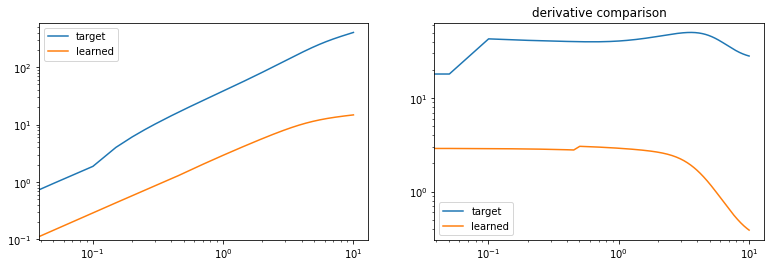

In [18]:
grad_real=[]
for i in np.array([tf.constant(i,dtype=float) for i in np.linspace(0, 10, num=200)]):
  x = tf.constant([i],dtype='float')
  with tf.GradientTape() as g:
    g.watch(x)
    y = R_real(x)
  grad_real.append(g.gradient(y, x)[0])

def performance_check(generator):
  plt.figure(figsize=(13,4))
  plt.subplot(121)
  # Real Generator Plot
  x_li = np.array([tf.constant(i,dtype=float) for i in np.linspace(0, 10, num=200)])
  y = [R_real(i) for i in x_li]
  plt.plot(tf.reshape(x_li,[-1]),tf.reshape(y,[-1]), label='target')
  # Plot fake R
  y = [R_learned(i) for i in x_li]
  plt.plot(tf.reshape(x_li,[-1]),tf.reshape(y,[-1]), label='learned')
  plt.yscale('log')
  plt.xscale('log')
  print('weighted L2 norm:',integrate.quad(SSE, 0, np.inf)[0])
  plt.legend()

  plt.subplot(122)
  plt.plot(tf.reshape(x_li,[-1]),grad_real,label='target')

  grad=[]
  for i in x_li:
    x = tf.constant([i],dtype='float')
    with tf.GradientTape() as g:
      g.watch(x)
      y = R_learned(x)
    grad.append(g.gradient(y, x)[0])
  plt.plot(tf.reshape(x_li,[-1]),grad,label='learned')
  plt.yscale('log')
  plt.xscale('log')
  plt.title('derivative comparison')
  plt.legend()

  plt.show()
performance_check(generator)

In [11]:
R_real(0.), R_learned(0.)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>)

## discriminator

In [12]:
discriminator = keras.Sequential(
    [
     Input(shape=(50,)),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(1)
    ],
    name="discriminator",
)


objective function

In [13]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.8):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    total_loss = real_loss + fake_loss
    
    return total_loss

## Optimizer

In [14]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2,
    decay_rate=0.96,
    staircase=True)
generator_optimizer = tf.keras.optimizers.RMSprop(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.002)

## Define trining_step

In [15]:
@tf.function
def training_step(generator, discriminator):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    g_z = tf.math.log(generator(50)) / 10
    d_x_true = discriminator(tf.math.log(tf.reshape(gen_gaps(theta_real,50), (1,50))) / 10)
    d_x_fake = discriminator(g_z)

    discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
    # Adjusting Gradient of Discriminator
    gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs

    generator_loss = generator_objective(d_x_fake)
    # Adjusting Gradient of Generator
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [16]:
def training(epoches):
  warnings.filterwarnings('ignore')
  for epoch in range(epoches):
    mse.append(integrate.quad(SSE, 0, np.inf)[0])
    training_step(generator, discriminator)
    if (epoch % 250) == 0: 
      print('epoch', epoch)
      performance_check(generator)
      # plt.plot(range(len(d_loss)),d_loss)

epoch 0
weighted L2 norm: 37.24691615693957


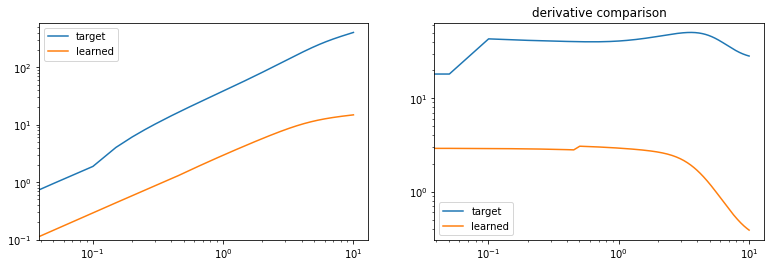

epoch 250
weighted L2 norm: 34.968235394838786


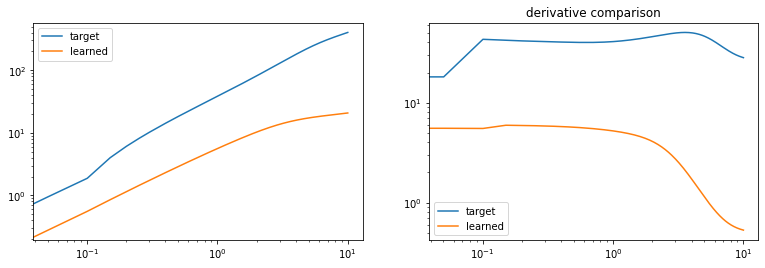

epoch 500
weighted L2 norm: 31.718564069124927


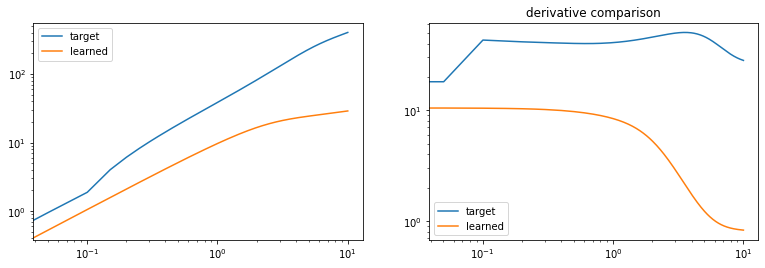

epoch 750
weighted L2 norm: 27.089087608182865


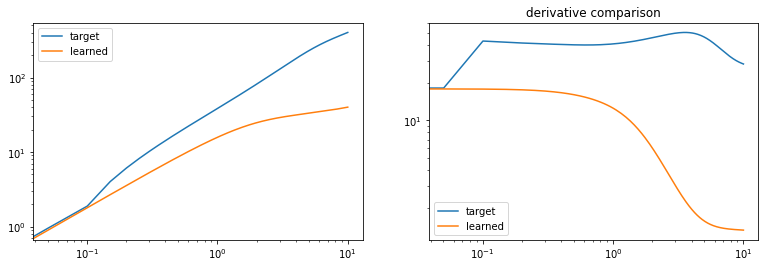

epoch 1000
weighted L2 norm: 20.74104817642148


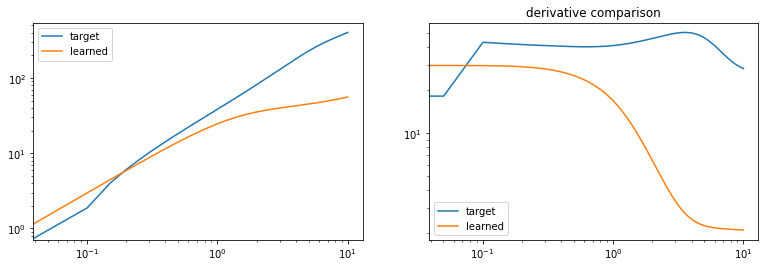

epoch 1250
weighted L2 norm: 15.137832793569


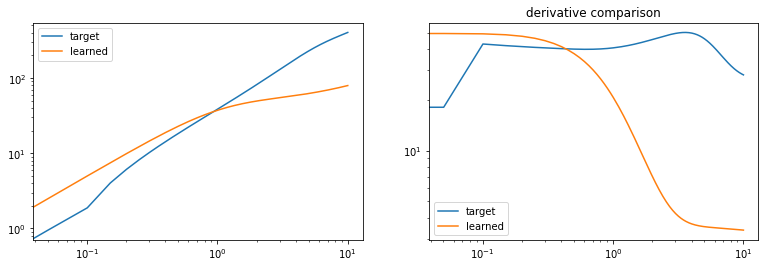

epoch 1500
weighted L2 norm: 17.581885498723363


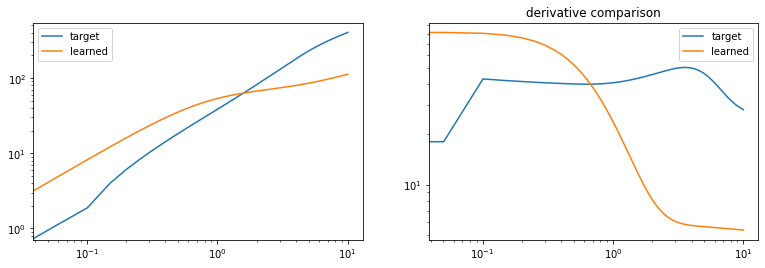

epoch 1750
weighted L2 norm: 16.7137547793623


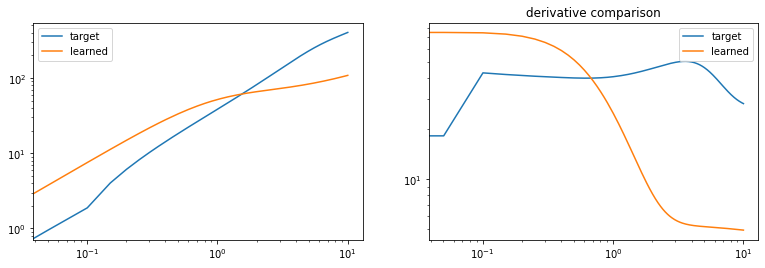

epoch 2000
weighted L2 norm: 14.121059367206243


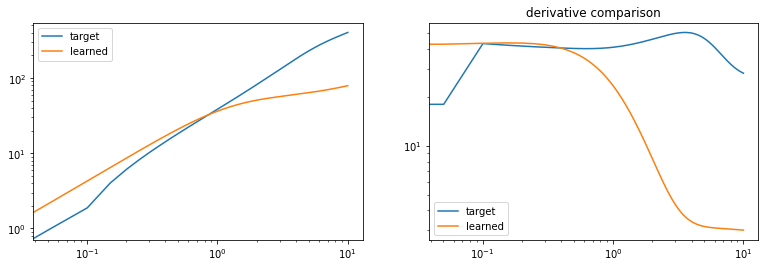

epoch 2250
weighted L2 norm: 20.548871206740447


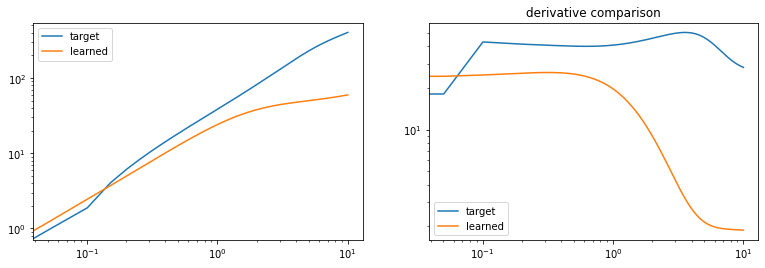

epoch 2500
weighted L2 norm: 27.063239961147286


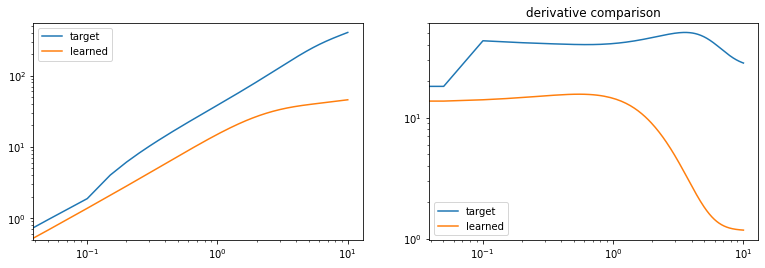

epoch 2750
weighted L2 norm: 31.88887271545879


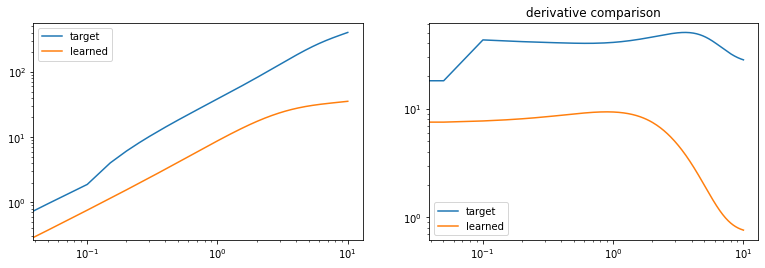

epoch 3000
weighted L2 norm: 32.15830906173694


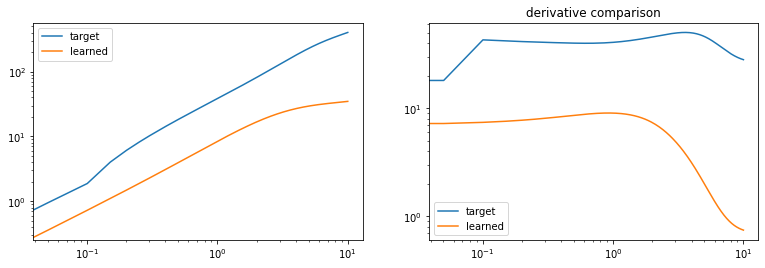

epoch 3250
weighted L2 norm: 26.950013682653182


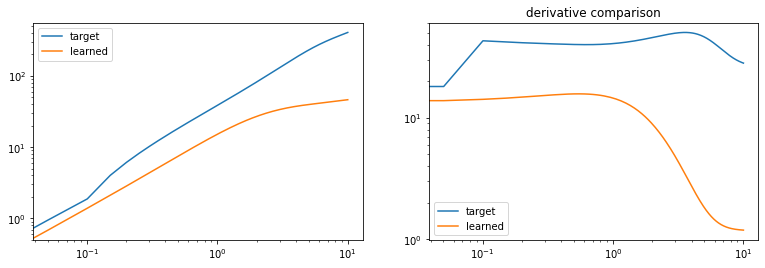

epoch 3500
weighted L2 norm: 20.222530225432394


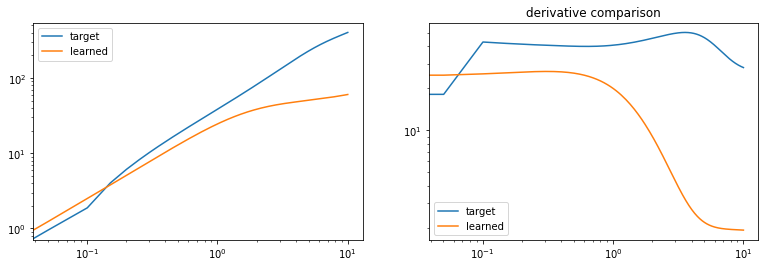

epoch 3750
weighted L2 norm: 17.401142327011577


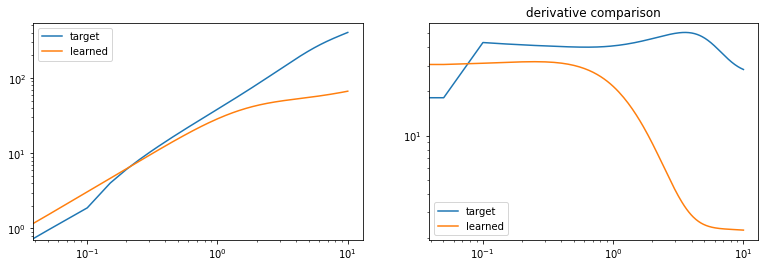

epoch 4000
weighted L2 norm: 24.96551401744928


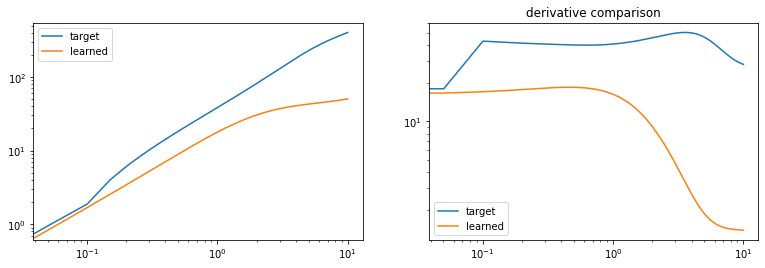

epoch 4250
weighted L2 norm: 23.322111950876153


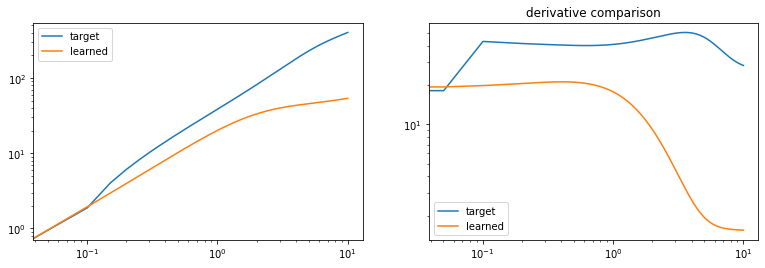

epoch 4500
weighted L2 norm: 17.44113424932004


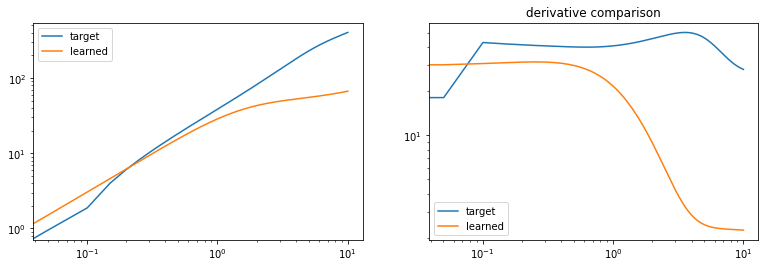

epoch 4750
weighted L2 norm: 25.044510413667133


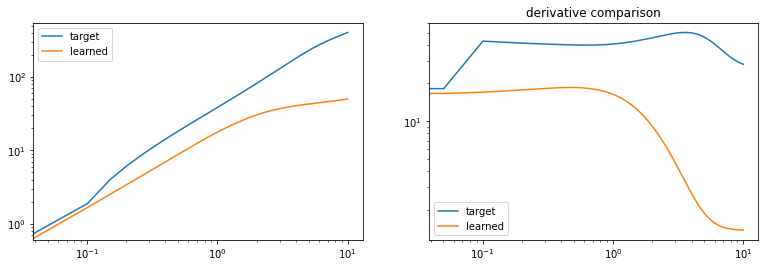

CPU times: user 4h 45min 37s, sys: 4min 17s, total: 4h 49min 55s
Wall time: 4h 48min 36s


In [23]:
%%time
mse = []
EPOCHES = 5000
training(EPOCHES)

Text(0.5, 1.0, 'minimum weighted l2 norm is at epoch: 1962 and has value 13.982297')

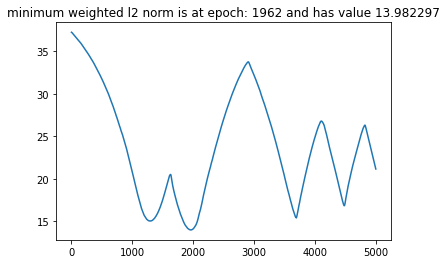

In [24]:
plt.plot(range(len(mse)),mse)
min_mse = min(mse)
min_pos = mse.index(min_mse)
plt.title(f"minimum weighted l2 norm is at epoch: {min_pos} and has value {min_mse:.6f}")